# Salary Prediction from LinkedIn Job Postings - Train XGBoost Model

In [33]:
import xgboost as xgb
import pandas as pd, numpy as np
import salary
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, TargetEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
import joblib

In [34]:
sns.set_theme()

## Train & Tune Model

In [35]:
(X_train, y_train) = salary.get_train_dataset()
(X_test, y_test) = salary.get_test_dataset()

In [36]:
preprocessor = make_pipeline(
    ColumnTransformer(
        transformers=[
            ('title_sbert_pca_encoder', make_pipeline(
                salary.SentenceBertEncoder(),
                StandardScaler(),
                PCA(n_components=0.9, random_state=42) 
            ), ['title']),
            ('location_sbert_pca_encoder', make_pipeline(
                salary.SentenceBertEncoder(),
                StandardScaler(),
                PCA(n_components=0.9, random_state=42) 
            ), ['location']),
            ('company_industries_sbert_pca_encoder', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='Unknown'),
                salary.SentenceBertEncoder(),
                StandardScaler(),
                PCA(n_components=0.9, random_state=42) 
            ), ['company_industries']),
            ('requirements_sbert_pca_encoder', make_pipeline(
                SimpleImputer(strategy='constant', fill_value='Unknown'),
                salary.SentenceBertEncoder(),
                StandardScaler(),
                PCA(n_components=0.9, random_state=42) 
            ), ['Educational_Requirements', 'Preferred_Qualifications', 'Required_Skills']),
            ('one_hot_encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['formatted_experience_level', 'formatted_work_type']),
            ('target_encoder', make_pipeline(
                TargetEncoder(random_state=42),
                StandardScaler(),
            ), ['norm_title', 'clustered_edu_req', 'clustered_pref_qual', 'clustered_req_skill', 'location_state', 'company_industries', 'formatted_experience_level', 'formatted_work_type']),
            ('experience_level', salary.experience_level_encoder, ['formatted_experience_level']),
            ('work_type', salary.work_type_encoder, ['formatted_work_type']),
            ('remote_allowed', 'passthrough', ['remote_allowed']),
            ('company_employee_count', make_pipeline(
                SimpleImputer(strategy='median'),
                StandardScaler(),
            ), ['company_employee_count']),
        ],
        remainder='drop'
    )
)

In [37]:
(train_size, num_features) = clone(preprocessor).fit_transform(X_train, y_train).shape
(train_size, num_features)

(27885, 693)

In [ ]:
model_xgb = make_pipeline(
    clone(preprocessor),
    BayesSearchCV(
        estimator=xgb.XGBRegressor(n_estimators=500, objective='reg:tweedie', random_state=42),
        search_spaces={
            'max_depth': (7,),
            'min_child_weight': (5,),  
            'eta': (0.1,), 
            'subsample': (0.9,),
            'colsample_bytree': (0.5,), 
            'gamma': (0,),  
            'reg_alpha': (100,), 
            'reg_lambda': (100,)  
        },
        scoring='r2',
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        n_iter=1, 
        n_jobs=1,
        verbose=1,
        random_state=42
    )
).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [39]:
model_xgb

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('title_sbert_pca_encoder',
                                                                   Pipeline(steps=[('sentencebertencoder',
                                                                                    SentenceBertEncoder()),
                                                                                   ('standardscaler',
                                                                                    StandardScaler()),
                                                                                   ('pca',
                                                                                    PCA(n_components=0.9,
                                                                                        random_state=42))]),
                                                                   ['title']),
                                                                  ('location_sbert_pca_encoder',
                                                                   Pipeline(steps=[('sentencebertencoder',...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=500,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...),
                               n_iter=1, random_state=42, scoring='r2',
                               search_spaces={'colsample_bytree': (0.5,),
                                              'eta': (0.1,), 'gamma': (0,),
                                              'max_depth': (7,),
                                              'min_child_weight': (5,),
                                              'reg_alpha': (10,),
                                              'reg_lambda': (10,),
                                              'subsample': (0.9,)},
                               verbose=1))])

In [40]:
model_xgb[-1].cv_results_

{'mean_fit_time': array([42.81814752]),
 'std_fit_time': array([6.45606739]),
 'mean_score_time': array([0.01915016]),
 'std_score_time': array([0.00342348]),
 'param_colsample_bytree': masked_array(data=[0.5],
              mask=[False],
        fill_value=1e+20),
 'param_eta': masked_array(data=[0.1],
              mask=[False],
        fill_value=1e+20),
 'param_gamma': masked_array(data=[0],
              mask=[False],
        fill_value=999999),
 'param_max_depth': masked_array(data=[7],
              mask=[False],
        fill_value=999999),
 'param_min_child_weight': masked_array(data=[5],
              mask=[False],
        fill_value=999999),
 'param_reg_alpha': masked_array(data=[10],
              mask=[False],
        fill_value=999999),
 'param_reg_lambda': masked_array(data=[10],
              mask=[False],
        fill_value=999999),
 'param_subsample': masked_array(data=[0.9],
              mask=[False],
        fill_value=1e+20),
 'params': [OrderedDict([('colsample_by

In [41]:
result_xgb_train = salary.evaluate_train_predictions(model_xgb.predict(X_train))
result_xgb_test = salary.evaluate_test_predictions(model_xgb.predict(X_test))

Train R2: 0.9921
Train RMSE: 5477.9044
Train MAE: 3584.2786
Test R2: 0.6282
Test RMSE: 35546.2693
Test MAE: 21507.2943


## Check Feature Importance

,Feature,Importance
0,one_hot_encoder__formatted_experience_level_Mid-Senior level,0.090583
1,experience_level__formatted_experience_level,0.084433
2,target_encoder__norm_title,0.051836
3,target_encoder__formatted_experience_level,0.03577
4,one_hot_encoder__formatted_experience_level_Unknown,0.033512
5,target_encoder__company_industries,0.031493
6,target_encoder__clustered_req_skill,0.029206
7,one_hot_encoder__formatted_work_type_Part-time,0.028299
8,target_encoder__clustered_edu_req,0.023619
9,requirements_sbert_pca_encoder__pca2,0.01764


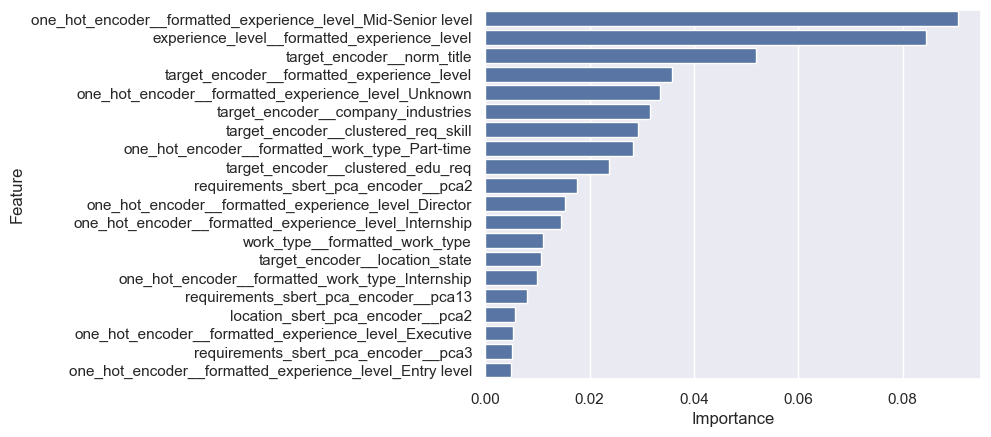

In [42]:
'''
Show top 20 important features
'''
def get_important_features(preocessor, model, n=20):
    feature_names = preocessor.get_feature_names_out(X_train.columns)
    importances = model.feature_importances_
    idxs = np.flip(np.argsort(np.abs(importances)))
    importance_df = pd.DataFrame([feature_names[idxs], importances[idxs]], index=["Feature", "Importance"]).transpose()
    sns.barplot(x="Importance", y="Feature", data=importance_df.head(n))
    pd.set_option('display.max_colwidth', None)
    return importance_df[:n]


get_important_features(model_xgb[0], model_xgb[-1].best_estimator_)

## Do Error Analysis

In [43]:
y_test_preds = model_xgb.predict(X_test)
resids = (y_test - y_test_preds).rename('residual')
abs_error = np.abs(resids).rename('abs_error')
X_test_results = pd.concat([X_test, y_test, pd.Series(y_test_preds, index=y_test.index, name='predicted_salary'), resids, abs_error], axis=1)
X_test_results

job_id                                           title  \
10953  3898168698  Staffing Industry Branch Manager - NYC office    
29454  3905289191                          Manufacturing Engineer   
21866  3903470856                   Physician Assistant Full Time   
5673   3889403735                                 Payroll Manager   
22924  3903832397         Data Analyst - Python/AWS (W2) (REMOTE)   
...           ...                                             ...   
13484  3901175485                             Family Law Attorney   
23772  3903895678                              Quality Technician   
27595  3904954999                      Sales & Leasing Specialist   
3410   3887570772  Heavy Civil Construction - Estimator (Asphalt)   
18220  3902347695                      Customer Care Professional   

                              location location_state  \
10953                     New York, NY             NY   
29454                         Cary, IL             IL   
21866                    Patchogue, NY             NY   
5673   New York City Metropolitan Area        Unknown   
22924                    United States        Unknown   
...                                ...            ...   
13484                    San Diego, CA             CA   
23772                       Tucson, AZ             AZ   
27595                      Mankato, MN             MN   
3410                      Marietta, GA             GA   
18220                      El Paso, TX             TX   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

<Axes: xlabel='residual', ylabel='Count'>

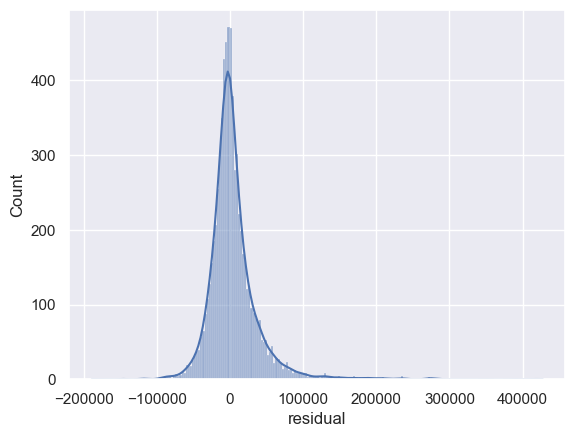

In [44]:
# Residuals look pretty normally distributed
sns.histplot(X_test_results['residual'], kde=True)

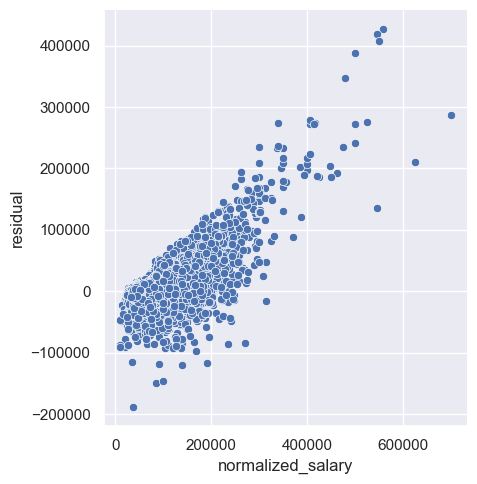

In [45]:
'''
In general, the higher the residual, the more the model underestimates the salary.
It sometimes overestimates the salary for lower salaries.
'''
sns.relplot(x='normalized_salary', y='residual', data=X_test_results, kind='scatter')

In [46]:
'''
Tends to underestimate (top 5): Nurse Practitioner, Phlebotomist, Associate Attorney, Electrical Engineer
Tends to overestimate (top 5): General Manager, Business Development Manager, Sales Representative, Accountant, Controller
'''
X_test_results.groupby('norm_title').agg({'residual': 'mean', 'norm_title': 'count'}).sort_values(by='residual')

,residual,norm_title
norm_title,,
General Manager,-2372.871348,43
Inside Sales Representative,-2094.934031,70
Business Development Manager,-1754.460959,74
Business Development Representative,-1702.255756,148
Program Manager,-1449.449353,113
...,...,...
Data Analyst,10658.626897,137
Medical Assistant,14627.442852,176
Mortgage Loan Officer,14955.819776,51


In [47]:
X_test_results.groupby('formatted_experience_level').agg({'abs_error': 'mean', 'formatted_experience_level': 'count'}).sort_values(by='abs_error')

,abs_error,formatted_experience_level
formatted_experience_level,,
Entry level,13755.828089,1765
Internship,15194.346523,59
Associate,17819.959455,777
Unknown,23281.192000,1582
Mid-Senior level,24647.128958,2466
Director,33918.093214,250
Executive,66261.030094,73


In [48]:
X_test_results.groupby('formatted_work_type').agg({'abs_error': 'mean', 'formatted_work_type': 'count'}).sort_values(by='abs_error')

,abs_error,formatted_work_type
formatted_work_type,,
Volunteer,7082.386719,2
Part-time,12332.191552,452
Internship,13812.963325,45
Temporary,16149.533854,69
Full-time,22046.322849,5632
Contract,23633.306887,748
Other,32584.808252,24


In [49]:
X_test_results.sort_values(by='abs_error')[['job_id', 'title', 'norm_title', 'location', 'formatted_work_type', 'formatted_experience_level', 'normalized_salary', 'predicted_salary', 'residual']].tail(20)

,job_id,title,norm_title,location,formatted_work_type,formatted_experience_level,normalized_salary,predicted_salary,residual
31441,3905375131,Real Estate Agent - Los Angeles (Oxnard),Mortgage Loan Officer,Los Angeles Metropolitan Area,Full-time,Unknown,405000.0,181926.437500,223073.562500
27147,3904928129,Orthodontist,Phlebotomist,"Parkersburg, WV",Full-time,Mid-Senior level,350000.0,116454.453125,233545.546875
24341,3904361874,Project Finance Associate - 1890298,Project Engineer,"Boston, MA",Full-time,Associate,337500.0,103899.257812,233600.742188
8393,3894572063,"Radiologist Opportunity in Fort Pierce, FL",Patient Care Technician,"Fort Pierce, FL",Full-time,Mid-Senior level,300000.0,64967.046875,235032.953125
32718,3905864166,Software Engineer,Software Engineer,Greater Chicago Area,Full-time,Mid-Senior level,475000.0,239859.312500,235140.687500
17528,3901981451,Life Insurance Sales,Sales Specialist,United States,Other,Unknown,340000.0,103190.835938,236809.164062
29214,3905259087,"Chief Product Officer, Slack",Senior Software Engineer,"San Francisco, CA",Full-time,Mid-Senior level,499000.0,257575.531250,241424.468750
14469,3901377257,Psychiatrist,Physical Therapist,"New York, United States",Contract,Unknown,415000.0,143019.078125,271980.921875
3045,3886899005,Senior Vice President of Retail Operations,Sales Executive,United States,Full-time,Executive,500000.0,227836.343750,272163.656250
27690,3904959000,Psychiatrist,Physical Therapist,"Grafton, OH",Part-time,Unknown,405600.0,132965.875000,272634.125000


## Export Best Model

In [50]:
joblib.dump(model_xgb, 'models/best_model_xgb.pkl')

['models/best_model_xgb.pkl']